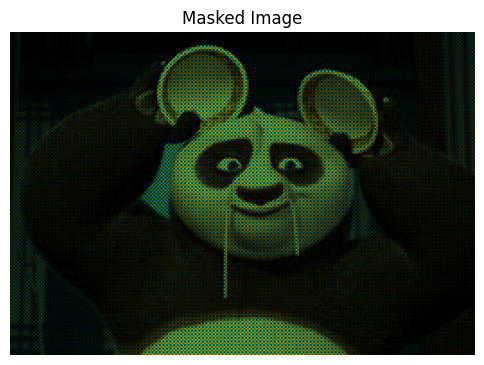

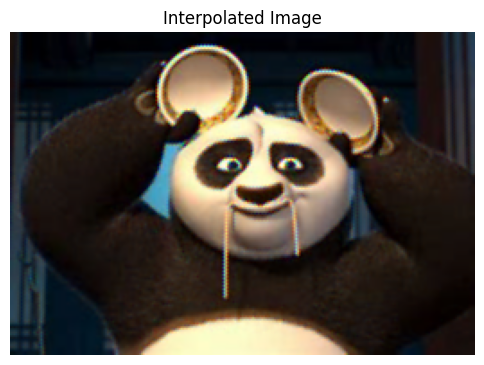

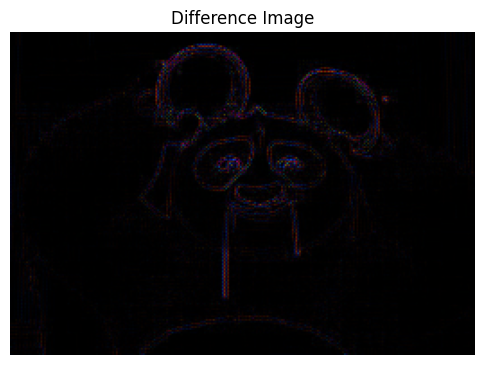

In [12]:
import numpy as np
from PIL import Image, ImageChops
import math
import matplotlib.pyplot as plt

def weight_func(x, y):
    if not (x or y):
        return 10000
    return 1 / math.sqrt(x**2 + y**2)

def create_mask(img, pattern, color):
    mask_h, mask_w = len(pattern), len(pattern[0])
    binary_mask = Image.new("1", size=img.size)
    pixels = binary_mask.load()
    for x in range(img.width):
        for y in range(img.height):
            pixels[x, y] = (pattern[y % mask_h][x % mask_w] == color)
    return binary_mask

def interpolate(img, bit_masks, weight_func, radius=1):
    ext_img = Image.new("RGB", (img.width + 2 * radius, img.height + 2 * radius))
    ext_img.paste(img, (radius, radius))

    result_bands = []

    for ch in range(3):
        ch_band = Image.new("L", img.size)
        ch_pixels = ch_band.load()

        value_acc = Image.new("F", (img.width + 2 * radius, img.height + 2 * radius))
        value_px = value_acc.load()

        weight_acc = Image.new("F", (img.width + 2 * radius, img.height + 2 * radius))
        weight_px = weight_acc.load()

        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                weight = weight_func(dx, dy)
                for x in range(radius, img.width + radius):
                    for y in range(radius, img.height + radius):
                        pixel_value = ext_img.getpixel((x, y))[ch]
                        value_px[x + dx, y + dy] += pixel_value * weight
                        weight_px[x + dx, y + dy] += bit_masks[ch].getpixel((x - radius, y - radius)) * weight

        for x in range(img.width):
            for y in range(img.height):
                wx, wy = x + radius, y + radius
                if weight_px[wx, wy] != 0:
                    ch_pixels[x, y] = int(value_px[wx, wy] / weight_px[wx, wy])
                else:
                    ch_pixels[x, y] = 0

        result_bands.append(ch_band)

    return Image.merge("RGB", result_bands)

def show_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.asarray(image))
    plt.axis("off")
    plt.title(title)
    plt.show()

mask_bayer = [['G', 'B'],
              ['R', 'G']]

color_map = {0: 'R', 1: 'G', 2: 'B'}

image_path = "po.jpg"
image = Image.open(image_path).convert("RGB")

pattern = mask_bayer

masks = [create_mask(image, pattern, color_map[ch]) for ch in range(3)]

channels = [Image.composite(image.split()[ch], Image.new("L", image.size), masks[ch]) for ch in range(3)]

merged_image = Image.merge("RGB", tuple(channels))
show_image(merged_image, "Masked Image")

demo_image = interpolate(merged_image, masks, weight_func, radius=1)
show_image(demo_image, "Interpolated Image")

difference = ImageChops.difference(demo_image, image)
show_image(difference, "Difference Image")
